# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Основные шаги</h1>

1. Загрузите данные, путь к файлу: /datasets/autos.csv.
2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
3. Подготовьте выборки для обучения моделей.
4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
5. Проанализируйте время обучения, время предсказания и качество моделей.
6. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

<h1>Примечания</h1>

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

<h1>Описание данных</h1>

Данные находятся в файле /datasets/autos.csv. Скачать датасет.

<h1>Признаки</h1> DateCrawled DateCreated LastSeen RegistrationYear RegistrationMonth

- *DateCrawled* — дата скачивания анкеты из базы
- *VehicleType* — тип автомобильного кузова
- *RegistrationYear* — год регистрации автомобиля
- *Gearbox* — тип коробки передач
- *Power* — мощность (л. с.)
- *Model* — модель автомобиля
- *Kilometer* — пробег (км)
- *RegistrationMonth* — месяц регистрации автомобиля
- *FuelType* — тип топлива
- *Brand* — марка автомобиля
- *Repaired* — была машина в ремонте или нет
- *DateCreated* — дата создания анкеты
- *NumberOfPictures* — количество фотографий автомобиля
- *PostalCode* — почтовый индекс владельца анкеты (пользователя)
- *LastSeen* — дата последней активности пользователя

<h1>Целевой признак</h1>

*Price — цена (евро)*

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, cv, train
import lightgbm
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

<h3>Загрузите данные, путь к файлу: /datasets/autos.csv.</h3>

In [ ]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<h3>Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.</h3>


In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Проблемные места датасета, которые необходимо решить:**

1. Столбец NumberOfPictures - ни одного пропуска, но какой в этом смысл если согласно дескрайбу он весь занулен? Он явно не поможет нам в обучении, скорее только собьет с толку модель
2. Есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired. Их нужно будет особенно изучить, понять природу и избавится от лишнего.
3. Столбцы DateCrawled, DateCreated, LastSeen - представлены не в общепринятом формате datetime
4. Столбцы PostalCode, RegistrationMonth - нужны ли для обучения?
5. Наименования столбцов не по ГОСТу!

Однако, последние три пункта - так ли необходимы? В целях соблюдения красоты данных, можно было бы провернуть подобные движения, чем я и займусь перед тем, как буду их выгружать в репозиторий, но сейчас главная задача - постороение моделей и выбор лучших, а данные столбцы не выглядят как подходящие фичи для обучения, в планах будет их жестоко убить!

<h4>Удалим зануленный столбец, и те, от которых при обучении не будет пользы</h4>

In [ ]:
data = data.drop(columns=['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen',
                      'PostalCode', 'RegistrationMonth'], axis=1)

<h4>Изучим солбцы с пропусками (VehicleType, Gearbox, Model, FuelType, Repaired)</h4>

Посмотрим, сколько потеряем, если просто все снесем

In [ ]:
for i in [data]:
    print('Количество пустых ячеек к заполненым:',((i.isnull().sum().sum()) / (i.shape[0] * i.shape[0])) * 100,'%')
    print('Количество пустых строк к заполненым:',((i.shape[0] - i.dropna().shape[0]) / i.shape[0]) * 100,'%')
    print('---------------------------------')

Количество пустых ячеек к заполненым: 0.00014419554559284603 %
Количество пустых строк к заполненым: 30.633322892239445 %
---------------------------------


Не любил четверти со школы, но сейчас их не полюбил вдовойне, вроде все пять признаков категориальные, придется видимо заменять все на пропуски "нет данных", чтобы не потерять информацию. Хотя хотелось изначально столбец рекваер привести к булевому, как будто так будет машине проще закономерности находить (мой субъективный взгляд, может быть не так), а с третьим параметром этого уже не провернешь(

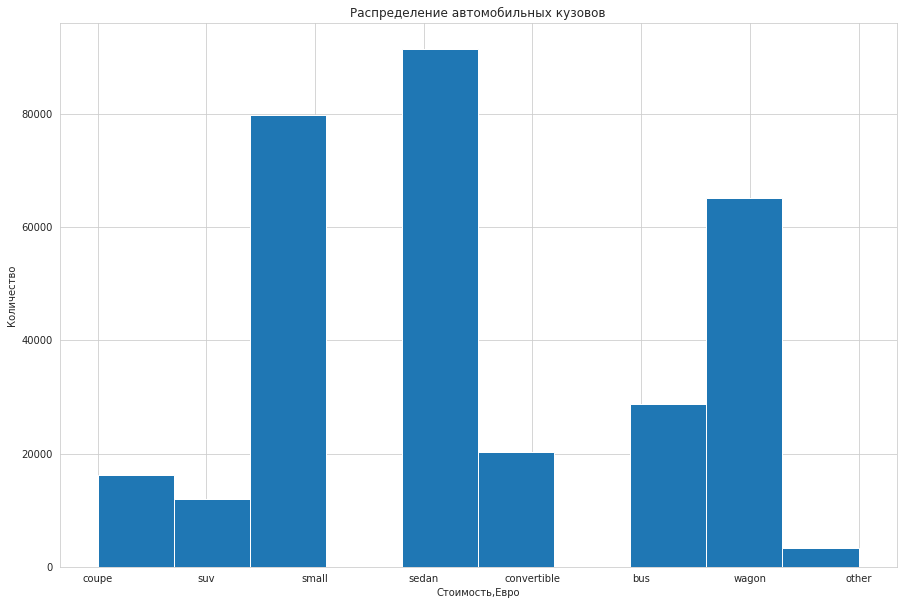

In [ ]:
sns.set_style('whitegrid')
data['VehicleType'].hist(bins=10,figsize=(15,10))
plt.title('Распределение автомобильных кузовов')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

Обычный категориальный признак, и мы видим, наш знак спасения - графа other, пропуски можно смело залить в нее

In [ ]:
data['VehicleType']=data['VehicleType'].fillna('other')

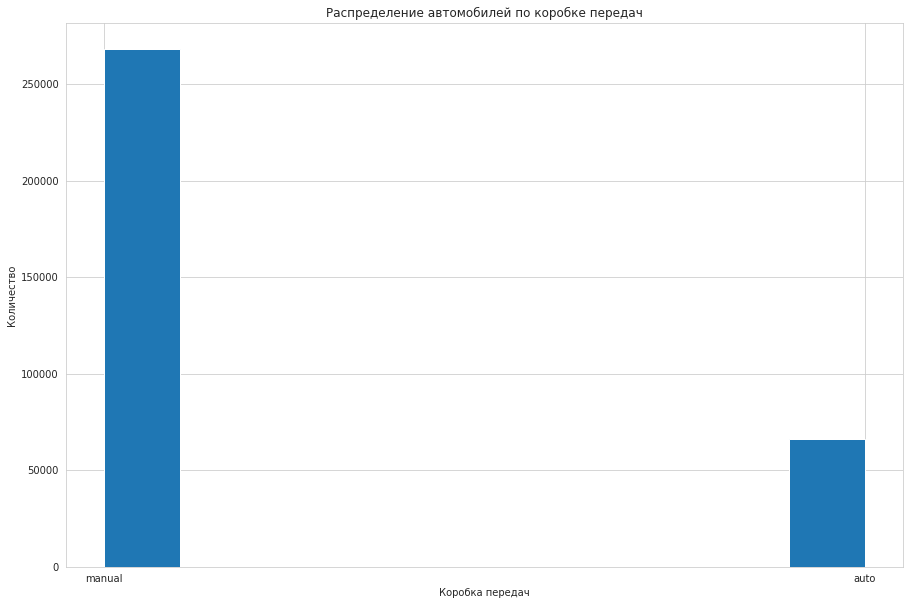

In [ ]:
sns.set_style('whitegrid')
data['Gearbox'].hist(bins=10,figsize=(15,10))
plt.title('Распределение автомобилей по коробке передач')
plt.xlabel('Коробка передач')
plt.ylabel('Количество')
plt.show()

Либо единица, либо нуль, чем заменять тоже нет вариантов, придется заменить на что тот же other.

In [ ]:
data['Gearbox']=data['Gearbox'].fillna('other')

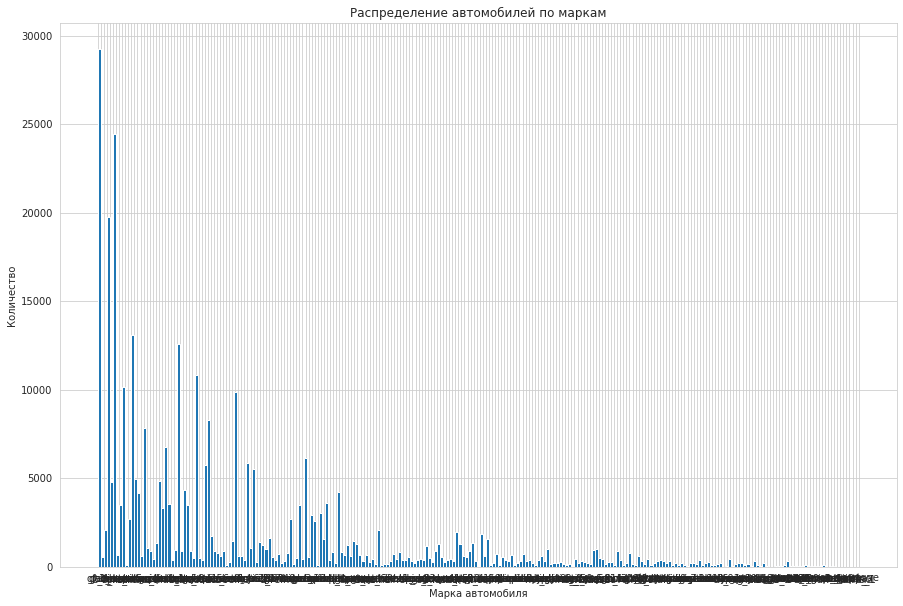

In [ ]:
sns.set_style('whitegrid')
data['Model'].hist(bins=251,figsize=(15,10))
plt.title('Распределение автомобилей по маркам')
plt.xlabel('Марка автомобиля')
plt.ylabel('Количество')
plt.show()

In [ ]:
data[data['Model'] == 'other']

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
24,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes
38,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no
52,1400,other,2016,manual,55,other,5000,NaN,hyundai,NaN
...,...,...,...,...,...,...,...,...,...,...
354290,2500,small,2007,manual,60,other,125000,petrol,hyundai,NaN
354302,5990,bus,1984,auto,0,other,70000,petrol,chevrolet,NaN
354316,3300,coupe,1957,manual,40,other,100000,petrol,trabant,no
354325,12800,convertible,1991,manual,211,other,150000,petrol,porsche,no


Тут other и без нас есть, значит в него и закинем пропуски!

In [ ]:
data['Model']=data['Model'].fillna('other')

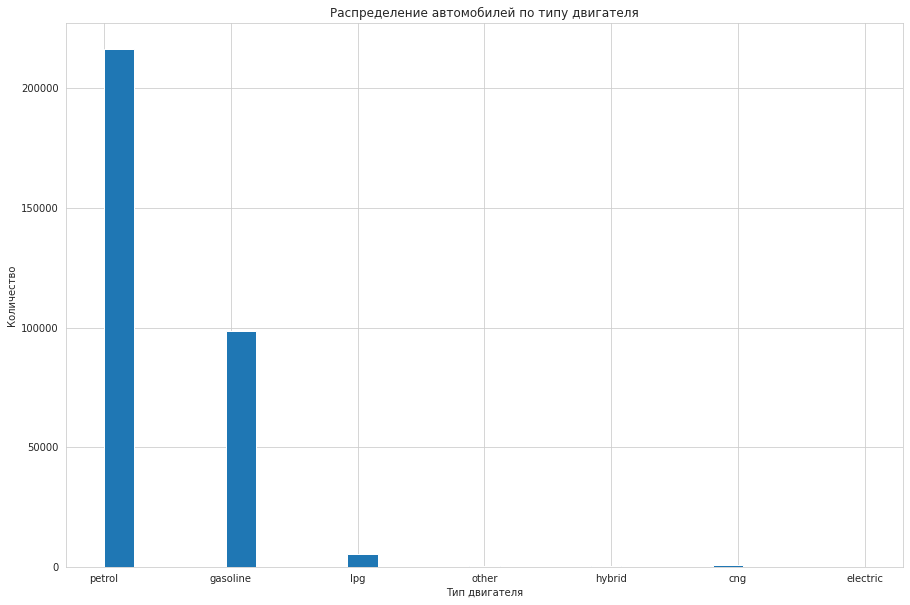

In [ ]:
sns.set_style('whitegrid')
data['FuelType'].hist(bins=25,figsize=(15,10))
plt.title('Распределение автомобилей по типу двигателя')
plt.xlabel('Тип двигателя')
plt.ylabel('Количество')
plt.show()

Так ли нам нужны последние колонки? Вопрос открытый, опять же все упирается в раритет, обычно маленький круг людей интересуется подобными вещами, но думаю можно пока что оставить!

In [ ]:
data['FuelType']=data['FuelType'].fillna('other')

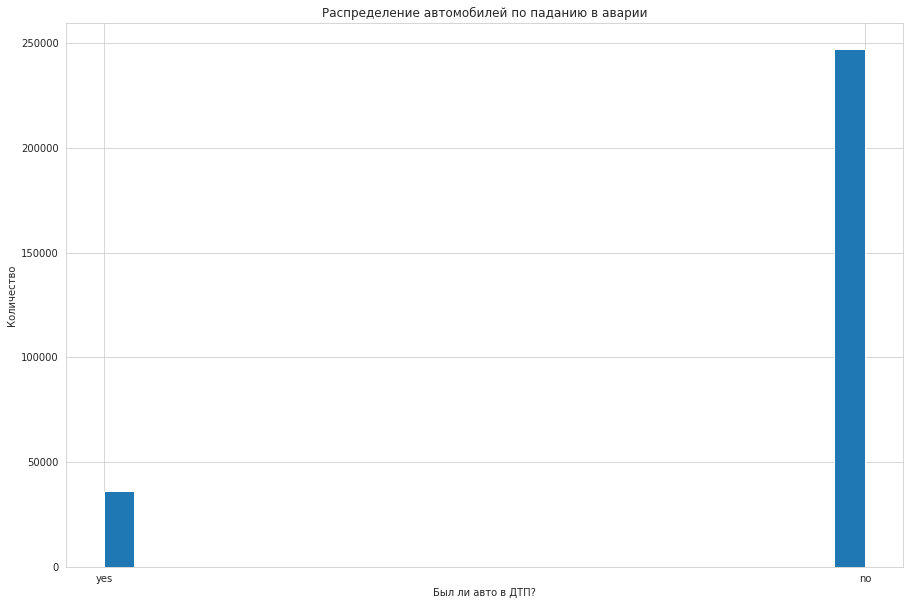

In [ ]:
sns.set_style('whitegrid')
data['Repaired'].hist(bins=25,figsize=(15,10))
plt.title('Распределение автомобилей по паданию в аварии')
plt.xlabel('Был ли авто в ДТП?')
plt.ylabel('Количество')
plt.show()

Заменить на озер, между да и нет, как-то странновато, удалять тоже мимо - снесется процентов 15-20, так как это столбец с наибольшими пропусками, но деваться некуда(

In [ ]:
data['Repaired']=data['Repaired'].fillna('other')

**Также в любом проекте необходимо привести наименование столбцов в порядок, сделаю это с помощью регулярного выражения, которое нашел на просторах интернета, а также избавимся от дубликатов**

In [ ]:
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.drop_duplicates(inplace=True)

<h4>Изучим оставшиеся признаки на неинформативные данные и выбросы</h4>

Из 16 столбцов, гистограммы 5 мы рассмотрели, 6 убрали из-за ненадобности, осталось 5! price, registration_year, power, kilometer,  brand. Раз пропусков в них нет, нужно проверить на выбросы! Более показательны выбросы на диаграмме ящика с усами, воспользуемся им!            

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309178 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              309178 non-null  int64 
 1   vehicle_type       309178 non-null  object
 2   registration_year  309178 non-null  int64 
 3   gearbox            309178 non-null  object
 4   power              309178 non-null  int64 
 5   model              309178 non-null  object
 6   kilometer          309178 non-null  int64 
 7   fuel_type          309178 non-null  object
 8   brand              309178 non-null  object
 9   repaired           309178 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.9+ MB


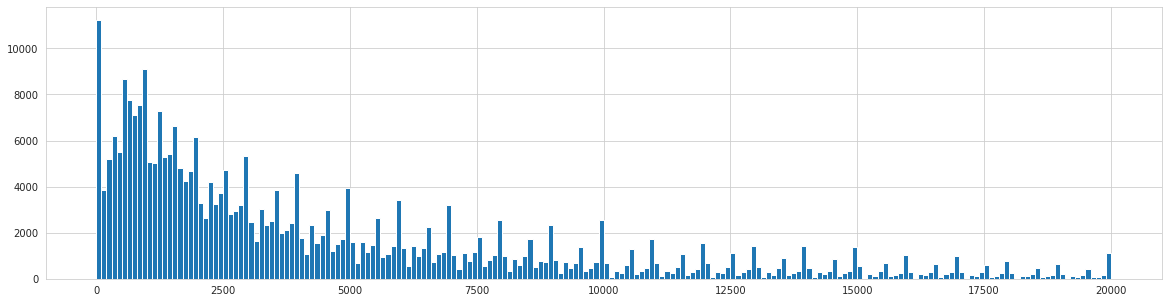

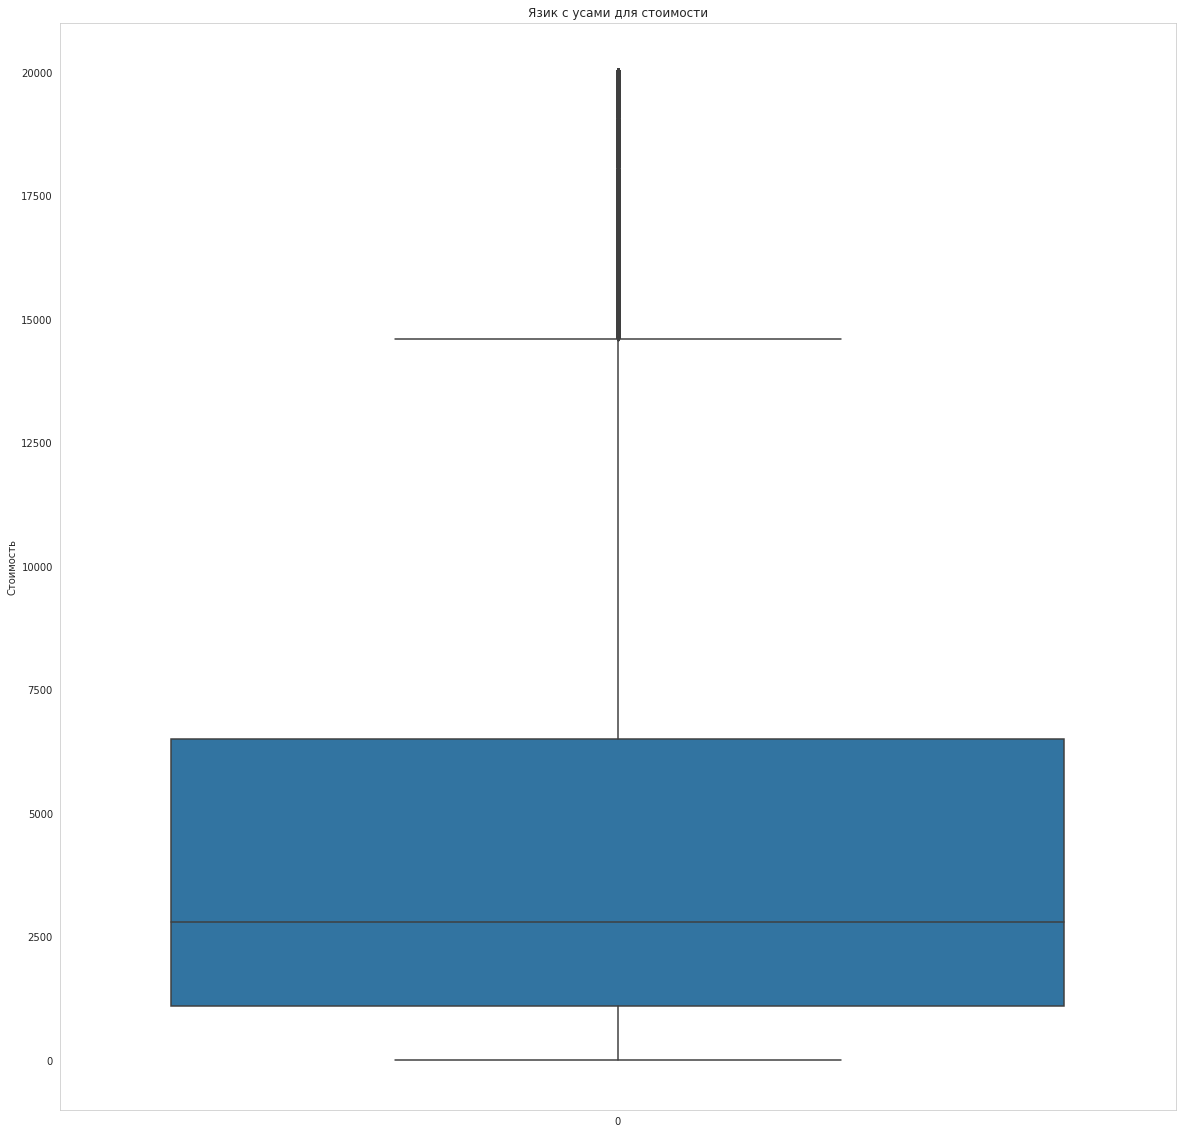

In [ ]:
data.price.hist(bins=200, figsize=(20,5))
plt.figure(figsize=(20, 20))
sns.boxplot(data=data['price'], orient='v')
#plt.xlim(-10, 500)
plt.title('Язик с усами для стоимости')
plt.ylabel('Стоимость')
plt.grid(False)
plt.show()

Видим реальные выбросы вышел 15к, от них стоит избавится. Почему цена может быть у нуля это коненчо странно, но вдруг кто-то отдает машины почти задаром? Хотя по гистограмме там их огромное количество, может быть по квантилям снесем экстримально выбивающиеся значения? С одной стороны потеряем 10 процентов данных, с другой мне кажется без них обучение пройдет гораздо оптимальнее, однако, и сама гистограмма достаточно странно выглядит, больше смахивает на экг (: Короче снесу их, думаю так оптимальнее, тем более мы не стали сносить пропуски и все их сохранили, хотя бы тут поубиваем что-нибудь

In [ ]:
data['price'].quantile([.05, 0.99])

0.05      200.0
0.99    18900.0
Name: price, dtype: float64

In [ ]:
data = data.query('200 <= price')

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 5900, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932,
       1950, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 3000, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       1600, 1111, 1039, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100,
       1300, 8200, 1946])

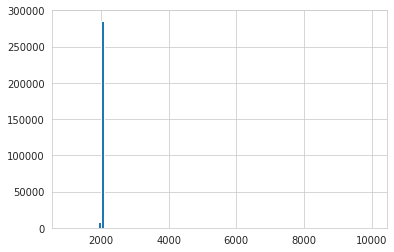

In [ ]:
data['registration_year'].hist(bins=100)
data['registration_year'].unique()

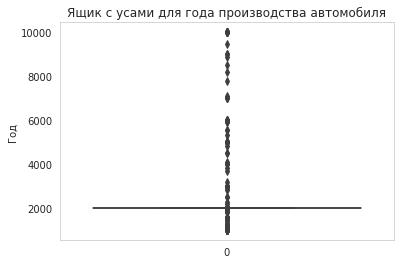

In [ ]:
sns.boxplot(data=data['registration_year'], orient='v')
#plt.xlim(-10, 500)
plt.title('Ящик с усами для года производства автомобиля')
plt.ylabel('Год')
plt.grid(False)
plt.show()

Какие то безумные графики, скорее всего по тому, что у нас огромное количество значений в промежутке 1900-2000, а остальные раскиданы вплоть до 10к единично, надо глянуть по квантилям и снести лишнее, выкинем по минимуму, так как выбросы единичные

In [ ]:
data['registration_year'].quantile([.01, 0.99])

0.01    1980.0
0.99    2018.0
Name: registration_year, dtype: float64

In [ ]:
data = data.query('1980 <= registration_year <= 2016')

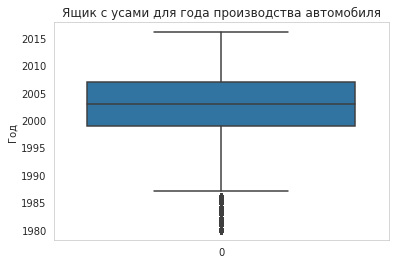

In [ ]:
sns.boxplot(data=data['registration_year'], orient='v')
#plt.xlim(-10, 500)
plt.title('Ящик с усами для года производства автомобиля')
plt.ylabel('Год')
plt.grid(False)
plt.show()

А вот это уже гораздо реалистичнее, выбросы вплоть до 80-ых, но думаю это опять же раритетные автомобили для ценителей.

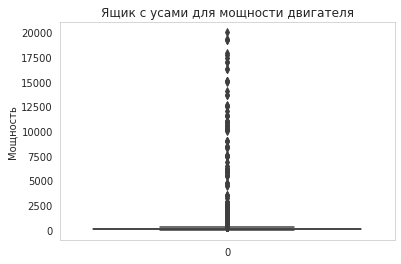

In [ ]:
sns.boxplot(data=data['power'], orient='v')
#plt.xlim(-10, 500)
plt.title('Ящик с усами для мощности двигателя')
plt.ylabel('Мощность')
plt.grid(False)
plt.show()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    50,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   232,   150,   156,
          80,    82,    90,   155,    54,   185,    87,   180,    86,
          84,   224,   235,   200,   178,   265,    77,   110,   144,
         120,   286,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,   145,
         280,   260,   104,   188,   333,   186,   117,   141,   132,
         234,   158,    39,    92,    51,   135,    59,   230,   209,
          43,   146,

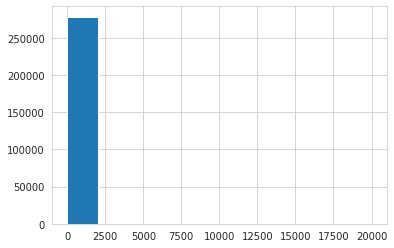

In [ ]:
data['power'].hist(bins=10)
data['power'].unique()

Ситуация аналогичная прошлому параметру. Я не особо знаю предметную область двигателей, скорее речь идет либо об объеме, либо о лошадиных силах, но выбросы вроде единичные, поэтому проще размазать их квантилями. В любом случае вариант 0 в плане мощности вряд ли подойдет!

In [ ]:
data['power'].quantile([.10, 0.99])

0.10     41.0
0.99    306.0
Name: power, dtype: float64

In [ ]:
data['power'].unique().sort ()

In [ ]:
data = data.query('power <= 1100')

<AxesSubplot:>

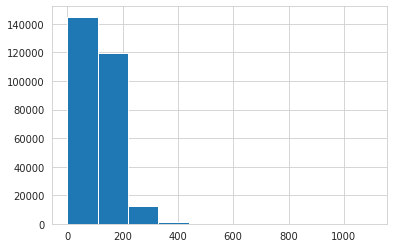

In [ ]:
data['power'].hist()

Теперь выглядит по-человечески!

<AxesSubplot:>

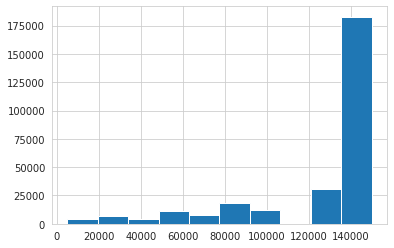

In [ ]:
data['kilometer'].hist()

Не вижу аномалий, в целом предполагаю, что в данном столбце ничего менять не нужно

In [ ]:
data['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'sonstige_autos', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

<AxesSubplot:>

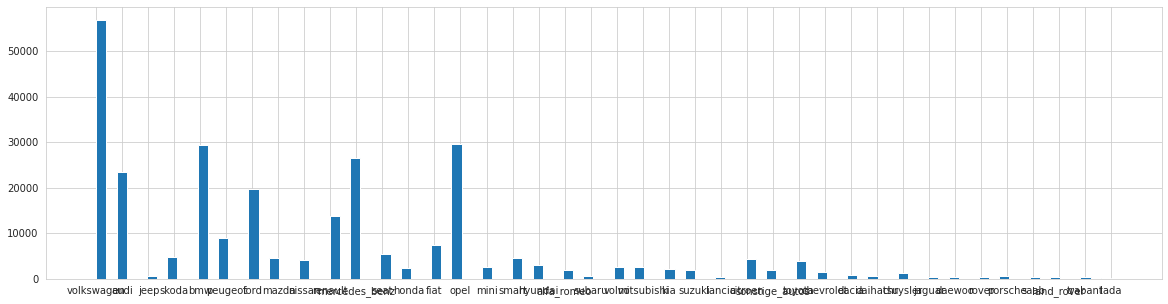

In [ ]:
data['brand'].hist(figsize=(20,5), bins = 100)

В целом обычный категориальный столбце, аномалий тут тоже не выявлено, гистограмма адекватна, правда я не могу придумать, как сделать надписи более читабельными в гистограмме(

**Вывод**
В ходе работы в данной главе подготовили данные для далнейшего обучения различных моделей с целью определения лучшей, пропусков нет, явных выбросов тоже, все достаточно цивильно, приступаем ко второй части проекта.

## Обучение моделей

В данной главе необходимо выполнить следующие шаги:
    
1. Подготовьте выборки для обучения моделей.
2. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
3. Проанализируйте время обучения, время предсказания и качество моделей.
4. Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Не забываем и о примечаниях:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

### Подготовьте выборки для обучения моделей

Необходимо разбить выборки для обучения, разобьем по классике 80-20-20. Так же воспользуемся ohe, для лучшего обучения.

In [ ]:
initial_data = data
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278203 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278203 non-null  int64 
 1   vehicle_type       278203 non-null  object
 2   registration_year  278203 non-null  int64 
 3   gearbox            278203 non-null  object
 4   power              278203 non-null  int64 
 5   model              278203 non-null  object
 6   kilometer          278203 non-null  int64 
 7   fuel_type          278203 non-null  object
 8   brand              278203 non-null  object
 9   repaired           278203 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.3+ MB


ord_enc = OrdinalEncoder(dtype=np.int64)
initial_data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.fit_transform(initial_data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])
initial_data.info()

In [ ]:
#data = data.drop(columns=['brand'])
#data = pd.get_dummies(data, columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], drop_first= True )

In [ ]:
#target = data['price']
#features = data.drop(['price'], axis=1)

In [ ]:
#features_80, features_test, target_80, target_test = train_test_split(
#    features, target, test_size=.2, random_state=42)
#features_train, features_valid, target_train, target_valid = train_test_split(
#    features_80, target_80, test_size=.25, random_state=42)


cat_features = data[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]

In [ ]:
initial_target = initial_data['price']
initial_features = initial_data.drop(['price'], axis=1)

initial_features_80, initial_features_test, initial_target_80, initial_target_test = train_test_split(
    initial_features, initial_target, test_size=.2, random_state=42)
initial_features_train, initial_features_valid, initial_target_train, initial_target_valid = train_test_split(
    initial_features_80, initial_target_80, test_size=.25, random_state=42)

ord_enc = OrdinalEncoder(dtype=np.int64)
initial_features_test_oe = initial_features_test
initial_features_train_oe = initial_features_train
initial_features_valid_oe = initial_features_valid
initial_features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.fit_transform(initial_features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])
initial_features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.fit_transform(initial_features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])
initial_features_valid_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.fit_transform(initial_features_valid_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])


In [ ]:
ord_enc = OrdinalEncoder(dtype=np.int64)
initial_features_test_oe = initial_features_test
initial_features_train_oe = initial_features_train
initial_features_valid_oe = initial_features_valid
initial_features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.fit_transform(initial_features_train_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])
initial_features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.transform(initial_features_test_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])
initial_features_valid_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']] = ord_enc.transform(initial_features_valid_oe[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']])

### Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры

Рассмотрим в рамках данной работы три модели: RandomForestRegressor, LightGBM и Catboost. Параметры буду подбирать пока что из рассчета времени, поэтому перебор будет узок, если ревьювер скажет уменьшить размер шага - подлатаем, но сидеть по 10 минут ждать у моря погоды печально:CC. Пришлось установить параметр cv = 3 (66 процентов под обучение в гридсерче не комильфо), для ускорения, что не может не сказаться на качестве, но рмсе меньше 2500 получить реально, просто не знаю, как у ревьюверов все проверяется, вероятно заново запускается и вероятно долго придется ждать

#### RandomForestRegressor

In [ ]:
%%time
rfr = RandomForestRegressor(random_state=42)
hyper = { 'max_depth': [x for x in range(1, 5, 1)],
               'n_estimators': [x for x in range(10, 20, 2)]
             }
gscv_rfr = GridSearchCV(rfr, hyper, cv=4, scoring='neg_mean_squared_error')
gscv_rfr.fit(initial_features_train_oe, initial_target_train)
print('Лучшие параметры: ', gscv_rfr.best_params_)
print('rfr_rmse', abs(gscv_rfr.best_score_)**0.5)

Лучшие параметры:  {'max_depth': 4, 'n_estimators': 18}
rfr_rmse 2570.342448353853
CPU times: user 55.6 s, sys: 151 ms, total: 55.8 s
Wall time: 55.8 s


Лучший показатель при глубине 4, и ветках = 18.

In [ ]:
%%time
model_rfr = RandomForestRegressor(max_depth = 4, n_estimators = 18, random_state=42)
model_rfr.fit(initial_features_train_oe, initial_target_train)

CPU times: user 1.77 s, sys: 11.7 ms, total: 1.78 s
Wall time: 1.78 s


RandomForestRegressor(max_depth=4, n_estimators=18, random_state=42)

In [ ]:
%%time
predict = model_rfr.predict(initial_features_valid_oe)

CPU times: user 34.1 ms, sys: 4.07 ms, total: 38.1 ms
Wall time: 37.1 ms


In [ ]:
rsme_rfr = mean_squared_error(initial_target_valid, predict) ** 0.5
rsme_rfr

2582.838305016378

#### CatBoostRegressor

In [ ]:
%%time
model_cbr = CatBoostRegressor(random_state=42)
hyper = { 'learning_rate': [0.1, 0.5, 0.9],
               'max_depth': [4], 'verbose':[False]
             }
grid_cbr = GridSearchCV(model_cbr, hyper, scoring='neg_mean_squared_error', cv = 3)
grid_cbr.fit(initial_features_train, initial_target_train,cat_features=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'])
print('Лучшие параметры: ', grid_cbr.best_params_)
print('rfr_rmse', abs(grid_cbr.best_score_)**0.5)

Лучшие параметры:  {'learning_rate': 0.5, 'max_depth': 4, 'verbose': False}
rfr_rmse 1626.049174025523
CPU times: user 13min 30s, sys: 6.72 s, total: 13min 37s
Wall time: 13min 51s


Лучший показатель при learning_rate = 0.5, но 12 минут гридсерча, несмотря на адекватные показатели метрики рмсе, должен сказать, что изначально максимальная глубина == 10, при ней все 45 минут отрабатывали.

In [ ]:
%%time
model_cbr = CatBoostRegressor(learning_rate = 0.5, max_depth = 4, verbose = False, random_state=42)
model_cbr.fit(initial_features_train, initial_target_train)

CPU times: user 21.3 s, sys: 183 ms, total: 21.5 s
Wall time: 23.4 s


In [ ]:
%%time
predict = model_cbr.predict(initial_features_valid)

CPU times: user 47.4 ms, sys: 3.99 ms, total: 51.4 ms
Wall time: 49.3 ms


In [ ]:
rsme_cbr = mean_squared_error(initial_target_valid, predict) ** 0.5
rsme_cbr

1580.2869002639443

#### LightGBM

In [ ]:
%%time
model_lgbm = LGBMRegressor(random_state=42)
hyper = { 'num_leaves': [20],
               'learning_rate': [0.1, 0.2, 0.3],
             }
grid_lgbm = GridSearchCV(model_lgbm, hyper, scoring='neg_mean_squared_error', cv = 3)
grid_lgbm.fit(initial_features_train_oe, initial_target_train)
print('Лучшие параметры: ', grid_lgbm.best_params_)
print('rfr_rmse', abs(grid_lgbm.best_score_)**0.5)

Лучшие параметры:  {'learning_rate': 0.3, 'num_leaves': 20}
rfr_rmse 1672.2476762653205
CPU times: user 15min 24s, sys: 12.1 s, total: 15min 36s
Wall time: 15min 41s


Лучший параметр - learning_rate = 0.3

In [ ]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=20, random_state= 42)
model_lgbmr.fit(initial_features_train_oe, initial_target_train)

CPU times: user 49.1 s, sys: 454 ms, total: 49.6 s
Wall time: 50.2 s


LGBMRegressor(learning_rate=0.3, num_leaves=20, random_state=42)

In [ ]:
%%time
target_predict = model_lgbmr.predict(initial_features_valid_oe)

CPU times: user 355 ms, sys: 0 ns, total: 355 ms
Wall time: 385 ms


In [ ]:
rsme_lgbmr_oe = mean_squared_error(initial_target_valid, predict) ** 0.5
rsme_lgbmr_oe

1580.2869002639443

## Анализ моделей

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Мы рассматривали RandomForestRegressor, LightGBM и Catboost

RandomForestRegressor:

- Качество предсказания - рмсе порядка 2600
- Скорость предсказания - 35.4 мс
- Время обучения -  Порядка 1.64 секунд

CatBoostRegressor:

- Качество предсказания - рмсе порядка 1650
- Скорость предсказания - 47.8 мс
- Время обучения -  Порядка 18.8 секунд

LightGBM:

- Качество предсказания - рмсе порядка 1600
- Скорость предсказания -  296  мс
- Время обучения -  1min 21s

Таким образом в первой версии проекта больше всего подходит LightGBM если выбирать точность, Случайный лес если выбирать скорость. Однако сбалансированным вариантом точности и скорости является CatBoostRegressor, воспользуемся ей для проверки на тестовой выборке

P.S: У меня очень нестабильно отрабатывает гридсерч и обучение, где-то за минуту, потом тот же код час, поэтому пришлось обойти очень мало параметров, какт только увеличиваешь шаг - в параметре бан на лишние 10 минут. Вероятно, проблема в ohe на 200+ столбцов параметра марки автомобиля, на 300+ фичах обучение даже обычное идет очень туго, не говоря о гридсерче, который обучается внутри по многу раз. Как это решить? Снести марки? Заранее спасибо, товарищ ревьювер!

In [ ]:
model_cbr = CatBoostRegressor(learning_rate = 0.5, max_depth = 4, verbose = False, random_state=42, cat_features=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'])
model_cbr.fit(initial_features_train, initial_target_train)
predict = model_cbr.predict(initial_features_test)
rsme_lgbmr_oe = mean_squared_error(initial_target_test, predict) ** 0.5
rsme_lgbmr_oe

1619.4309339643248

Получили значения удовлетворяющие условию

## Общий вывод

- Успешно ознакомились и предобработали данные, как смогли.
- Познакомились с новыми моделями с бустингом, изучили гиперпараметры.
- Проанализировали важные для заказчика параметры с целью выбрать одну лучшую модель.
- Проверили лучшую модель на тестовой выборке - получили адекватные значения.